# PS5
## Siyuan Peng

In [43]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy.integrate import quad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from matplotlib.ticker import FuncFormatter

# 1

## (a)

In [2]:
def to_percent(y, position):
    s = str(round(100 * y, 4))

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

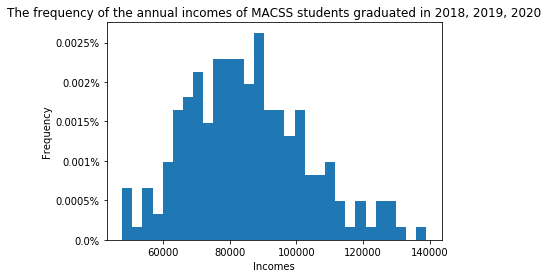

In [4]:
incomes = np.loadtxt('data/incomes.txt')
fig,ax = plt.subplots(figsize=(6,4))
ax.set_xlabel('Incomes')
ax.set_ylabel('Frequency')
ax.set_title('The frequency of the annual incomes of MACSS students graduated in 2018, 2019, 2020')
ax.hist(x=incomes, bins=30, normed=True)
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## (b)

In [20]:
def lognorm(x, mu=11, sigma=0.5):
    return sts.lognorm.pdf(x,s = abs(sigma), scale = np.exp(mu))
def data_moments(data):
    mean_data = data.mean()
    std_data = data.std()
    return mean_data, std_data
def model_moments(mu, sigma):
    mean_model = np.exp(mu+(sigma**2)/2)
    std_model = np.sqrt(np.exp(2*mu+sigma**2)*(np.exp(sigma**2)-1))
    return mean_model, std_model

In [21]:
def err_vec(data, mu, sigma, simple):
    mean_data, std_data = data_moments(data)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec
def criterion(params, *args):
    mu, sigma = params
    data, W = args
    err = err_vec(data, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val[0,0]

In [31]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion, params_init, args=gmm_args, tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-2, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
crit_val1 = criterion(results.x,*gmm_args)
print('The value of my GMM criterion function at the estimated parameter values is', crit_val1)

mu_GMM1= 11.33188086182164  sig_GMM1= 0.20869665294140677
The value of my GMM criterion function at the estimated parameter values is 9.517152363069554e-16


In [32]:
mean_data, std_data = data_moments(incomes)
print('The mean of data is',mean_data)
print('The standard deviation of data is',std_data)

mean_model1, std_model1 = model_moments(mu_GMM1, sig_GMM1)
print('The mean of initial model is',mean_model1)
print('The standard deviation of initial model is',std_model1)

err1 = err_vec(incomes, mu_GMM1, sig_GMM1, False).reshape(2,)
print('Error vector=', err1)

The mean of data is 85276.82360625811
The standard deviation of data is 17992.542128046523
The mean of initial model is 85276.82499059348
The standard deviation of initial model is 17992.54165604107
Error vector= [ 1.62334302e-08 -2.62333944e-08]


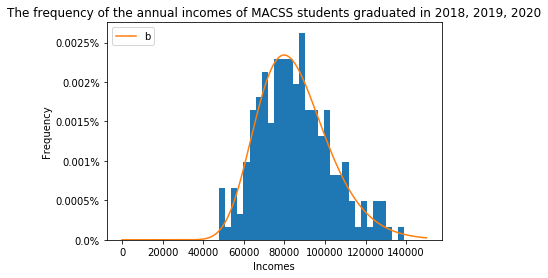

In [33]:
x_vec = np.linspace(0,150000, 150001)
fig,ax = plt.subplots()
ax.set_xlabel('Incomes')
ax.set_ylabel('Frequency')
ax.set_title('The frequency of the annual incomes of MACSS students graduated in 2018, 2019, 2020')
ax.hist(x=incomes, bins=30, normed=True)
ax.plot(x_vec, lognorm(x_vec, mu_GMM1, sig_GMM1), label='b')
plt.legend(loc='upper left')
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## (c)

In [34]:
def get_Err_mat2(mu, sigma, data = incomes, simple=False):
    R = 2
    N = len(data)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = data - mean_model
        Err_mat[1, :] = np.sqrt(((mean_data - data) ** 2)) - std_model
    else:
        Err_mat[0, :] = (data - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt(((mean_data - data) ** 2)) - std_model) / std_model
    
    return Err_mat
Err_mat = get_Err_mat2(mu_GMM1, sig_GMM1)
VCV2 = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = np.linalg.pinv(VCV2)
print(W_hat2)

[[0.04451671 0.02724079]
 [0.02724079 0.40593057]]
[[23.42542666 -1.57201052]
 [-1.57201052  2.5689684 ]]


In [35]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
new_gmm_args = (incomes, W_hat2)
new_results = opt.minimize(criterion, params_init, args=new_gmm_args, tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-2, None)))
mu_GMM2, sig_GMM2 = new_results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
crit_val2 = criterion(new_results.x,*gmm_args)
print('The value of my GMM criterion function at the estimated parameter values is', crit_val2)

mu_GMM2= 11.33188084068797  sig_GMM2= 0.2086966570748847
The value of my GMM criterion function at the estimated parameter values is 7.060901570969943e-16


In [36]:
mean_data, std_data = data_moments(incomes)
print('The mean of data is',mean_data)
print('The standard deviation of data is',std_data)

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM1)
print('The mean of initial model is',mean_model2)
print('The standard deviation of initial model is',std_model2)

err2 = err_vec(incomes, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Error vector=', err2)

The mean of data is 85276.82360625811
The standard deviation of data is 17992.542128046523
The mean of initial model is 85276.82318838131
The standard deviation of initial model is 17992.541275792653
Error vector= [-4.03759565e-09 -2.62638150e-08]


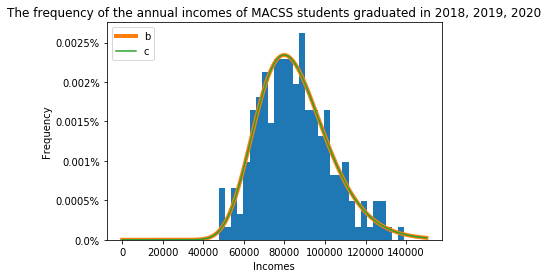

In [38]:
x_vec = np.linspace(0,150000, 150001)
fig,ax = plt.subplots()
ax.set_xlabel('Incomes')
ax.set_ylabel('Frequency')
ax.set_title('The frequency of the annual incomes of MACSS students graduated in 2018, 2019, 2020')
ax.hist(x=incomes, bins=30, normed=True)
ax.plot(x_vec, lognorm(x_vec, mu_GMM1, sig_GMM1), label='b', linewidth=4)
ax.plot(x_vec, lognorm(x_vec, mu_GMM2, sig_GMM2), label='c')
plt.legend(loc='upper left')
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

Considering that the $\mu$ and $\sigma$ are close to each other, the plots overlap each other as well.

## (d)

In [39]:
def new_data_moments(data):
    moment1 = np.mean((data<75000))
    moment3 = np.mean((data>100000))
    moment2 = 1-moment1-moment3
    return moment1, moment2, moment3
def new_model_moments(mu, sigma):
    moment1 = quad(lambda x: lognorm(x, mu, sigma), 0, 75000)[0]
    moment2 = quad(lambda x: lognorm(x, mu, sigma),75000,100000)[0]
    moment3 = quad(lambda x: lognorm(x, mu, sigma), 100000, np.inf)[0]
    return moment1, moment2, moment3

In [40]:
def new_err_vec(data, mu, sigma, simple):
    moment1_data, moment2_data, moment3_data = new_data_moments(data)
    moms_data = np.array([moment1_data, moment2_data, moment3_data]).reshape(3,1)
    moment1_model, moment2_model, moment3_model = new_model_moments(mu, sigma)
    moms_model = np.array([moment1_model, moment2_model, moment3_model]).reshape(3,1)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec
def new_criterion(params, *args):
    mu, sigma = params
    data, W = args
    err = new_err_vec(data, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val[0,0]

In [55]:
W_hat = np.eye(3)
gmm_args2 = (incomes, W_hat)
new_results = opt.minimize(new_criterion, params_init, args=gmm_args2, tol=1e-14,
                       method='L-BFGS-B',bounds=((None, None), (1e-2, None)))
new_mu_GMM1 = new_results.x[0]
new_sig_GMM1 = new_results.x[1]
print('mu_GMM1=', new_mu_GMM1, ' sig_GMM1=', new_sig_GMM1)
new_crit_val1 = new_criterion(new_results.x,*gmm_args2)
print('The value of my GMM criterion function at the estimated parameter values is', new_crit_val1)

mu_GMM1= 11.3356813274248  sig_GMM1= 0.21059845372071404
The value of my GMM criterion function at the estimated parameter values is 2.5337663578999387e-15


In [47]:
moment1_data, moment2_data, moment3_data = new_data_moments(incomes)
print('Moment 1 of points is {},Moment 2 of points is {}, Moment 3 of points is {}'.format(moment1_data, moment2_data, moment3_data))

moment1_model, moment2_model, moment3_model = new_model_moments(new_mu_GMM1, new_sig_GMM1)
print('Moment 1 of model is {},Moment 2 of model is {}, Moment 3 of points is {}'.format(moment1_model, moment2_model, moment3_model))

new_err1 = new_err_vec(incomes, new_mu_GMM1, new_sig_GMM1, False).reshape(3,1)
print('Error vector= \n', new_err1)

Moment 1 of points is 0.3,Moment 2 of points is 0.49999999999999994, Moment 3 of points is 0.2
Moment 1 of model is 0.30000000363345036,Moment 2 of model is 0.50000000585345, Moment 3 of points is 0.19999999051309977
Error vector= 
 [[ 1.21115012e-08]
 [ 1.17069000e-08]
 [-4.74345012e-08]]


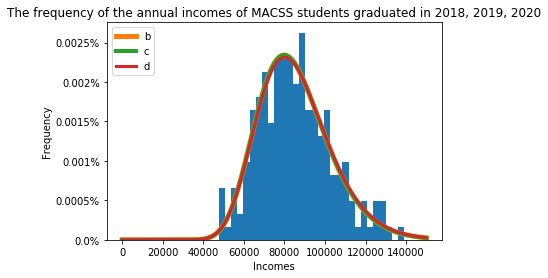

In [48]:
x_vec = np.linspace(0,150000, 150001)
fig,ax = plt.subplots()
ax.set_xlabel('Incomes')
ax.set_ylabel('Frequency')
ax.set_title('The frequency of the annual incomes of MACSS students graduated in 2018, 2019, 2020')
ax.hist(x=incomes, bins=30, normed=True)
ax.plot(x_vec, lognorm(x_vec, mu_GMM1, sig_GMM1), label='b', linewidth=5)
ax.plot(x_vec, lognorm(x_vec, mu_GMM2, sig_GMM2), label='c', linewidth=4)
ax.plot(x_vec, lognorm(x_vec, new_mu_GMM1, new_sig_GMM1), label='d', linewidth=3)
plt.legend(loc='upper left')
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## (e)

In [50]:
def new_get_Err_mat(mu, sigma, data = incomes, simple=False):
    R = 3
    N = len(data)
    Err_mat = np.zeros((R, N))
    moment1,moment2,moment3 = new_model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = (data<75000) - moment1
        Err_mat[1, :] = (data<=100000)&(data>=75000) - moment2
        Err_mat[2, :] = (data>100000) - moment3
    else:
        Err_mat[0, :] = ((data<75000) - moment1)/moment1
        Err_mat[1, :] = (((data<=100000)&(data>=75000)) - moment2)/moment2
        Err_mat[2, :] = ((data>100000) - moment3)/moment3
    
    return Err_mat
new_Err_mat = new_get_Err_mat(new_mu_GMM1, new_sig_GMM1)
new_VCV2 = (1 / incomes.shape[0]) * (new_Err_mat @ new_Err_mat.T)
print(new_VCV2)
new_W_hat2 = np.linalg.pinv(new_VCV2)
print(new_W_hat2)

[[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000004]
 [-1.00000004 -1.00000004  4.00000038]]
[[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [52]:
params_init = np.array([new_mu_GMM1, new_sig_GMM1])
new_gmm_args2 = (incomes, new_W_hat2)
new_results2 = opt.minimize(new_criterion, params_init, args=new_gmm_args2, tol=1e-14,
                       method='L-BFGS-B',bounds=((None, None), (1e-2, None)))
new_mu_GMM2, new_sig_GMM2 = new_results2.x
print('mu_GMM2=', new_mu_GMM2, ' sig_GMM2=', new_sig_GMM2)
new_crit_val2 = new_criterion(new_results2.x,*new_gmm_args2)
print('The value of my GMM criterion function at the estimated parameter values is', new_crit_val2)

mu_GMM2= 11.335681327424515  sig_GMM2= 0.21059845372108843
The value of my GMM criterion function at the estimated parameter values is 5.625386253428563e-16


In [53]:
moment1_data, moment2_data, moment3_data = new_data_moments(incomes)
print('Moment 1 of points is {},Moment 2 of points is {}, Moment 3 of points is {}'.format(moment1_data, moment2_data, moment3_data))

moment1_model2, moment2_model2, moment3_model2 = new_model_moments(new_mu_GMM2, new_sig_GMM2)
print('Moment 1 of model is {},Moment 2 of model is {}, Moment 3 of points is {}'.format(moment1_model2, moment2_model2, moment3_model2))

new_err2 = new_err_vec(incomes, new_mu_GMM2, new_sig_GMM2, False).reshape(3,1)
print('Error vector= \n', new_err2)

Moment 1 of points is 0.3,Moment 2 of points is 0.49999999999999994, Moment 3 of points is 0.2
Moment 1 of model is 0.30000000363345036,Moment 2 of model is 0.50000000585345, Moment 3 of points is 0.19999999051309977
Error vector= 
 [[ 1.21115012e-08]
 [ 1.17069000e-08]
 [-4.74345012e-08]]


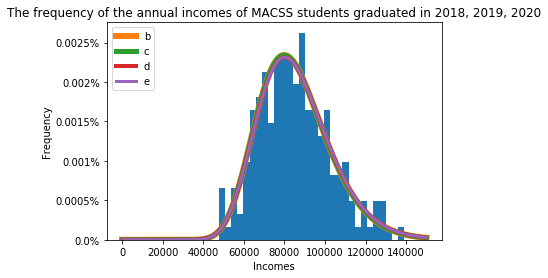

In [54]:
x_vec = np.linspace(0,150000, 150001)
fig,ax = plt.subplots()
ax.set_xlabel('Incomes')
ax.set_ylabel('Frequency')
ax.set_title('The frequency of the annual incomes of MACSS students graduated in 2018, 2019, 2020')
ax.hist(x=incomes, bins=30, normed=True)
ax.plot(x_vec, lognorm(x_vec, mu_GMM1, sig_GMM1), label='b', linewidth=6)
ax.plot(x_vec, lognorm(x_vec, mu_GMM2, sig_GMM2), label='c', linewidth=5)
ax.plot(x_vec, lognorm(x_vec, new_mu_GMM1, new_sig_GMM1), label='d', linewidth=4)
ax.plot(x_vec, lognorm(x_vec, new_mu_GMM2, new_sig_GMM2), label='e', linewidth=3)
plt.legend(loc='upper left')
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## (f)

In [56]:
print('The comparision of values of different GMM criterion functions shows as follows:')
print('b is {}, c is {}, d is {}, e is {}'.format(crit_val1, crit_val2, new_crit_val1, new_crit_val2))

The comparision of values of different GMM criterion functions shows as follows:
b is 9.517152363069554e-16, c is 7.060901570969943e-16, d is 2.5337663578999387e-15, e is 5.625386253428563e-16


It is clear that we shall choose e which has the smallest criterion value. It is quite straight forward that e is better than d, because d is just the first step of e. As for the difference between b,c and d,e, different moments actually make this improvement.

# 2

In [57]:
text = []
with open('data/sick.txt') as f:
    for line in f:
        text.append(line.rsplit()[0].split(','))
text = np.array(text)
df = pd.DataFrame(text[1:], columns=['sick', 'age', 'children', 'temp_winter']).astype('float64')
df.head()

,sick,age,children,temp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [60]:
def err_vec(y, x1, x2, x3, b0, b1, b2, b3, simple):
    betaX = b0 + b1*x1 + b2*x2 + b3*x3
    if simple:
        return betaX-y
    else:
        return (betaX-y)/y
    
def crit(params, *args):
    b0, b1, b2, b3 = params
    y, x1, x2, x3, W = args
    err = err_vec(y, x1, x2, x3, b0, b1, b2, b3, True)
    val_crit = err.T @ W @ err
    return val_crit

In [69]:
params_init = np.array([1, 0, 0, 0])
W_hat = np.eye(200)
gmm_args = (df.sick, df.age, df.children, df.temp_winter, W_hat)
res = opt.minimize(crit, params_init, args=(gmm_args),tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = res.x
val_crit = res.fun
print('b0 = {}, b1 = {}, b2 = {}, b3 = {}'.format(round(b0,4), round(b1,4), round(b2,4), round(b3,5)))
print('The value of the GMM criterion function evaluated at the optimal parameter is ',val_crit)

b0 = 0.2516, b1 = 0.0129, b2 = 0.4005, b3 = -0.00999
The value of the GMM criterion function evaluated at the optimal parameter is  0.001821289806039237
